# Imports
---


In [1]:
%pip install pykan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 4.5 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
from numpy.random import normal
from numpy.linalg import inv
from scipy.signal import cont2discrete
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from numpy import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
from kan import KAN
from kan.utils import create_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.metrics import accuracy_score
import sympy

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


# Loading Dataset

In [3]:

path_to_normal = os.path.join("/content/solution_no_attack.npy")
path_to_attacked = os.path.join("/content/solution_attacked.npy")

data_solution_no_attack = np.load(path_to_normal)
data_solution_attacked = np.load(path_to_attacked)
print("No Attack shape : " , data_solution_no_attack.shape)
print("Attack shape : " ,  data_solution_attacked.shape)


# Extract time points from the first solution's first row
time_points = data_solution_no_attack[0, 0, 2:]

# Exclude the time points row from the first solution
solution_no_attack = data_solution_no_attack[1:]
solution_attacked = data_solution_attacked[1:]

# Exclude the columns corresponding to u_1 and u_2
solution_no_attack = solution_no_attack[:, :, 2:]
solution_attacked = solution_attacked[:, :, 2:]


Nsol = solution_no_attack.shape[0]
dpoints = solution_no_attack.shape[2]
ndim = solution_no_attack.shape[1]
display(f"Number of solutions: {Nsol}",f"Number of datapoints per solution: {dpoints}", f"Number of measurments: {ndim}")



def set_random_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)

random_seed = 1234
set_random_seed(random_seed)


train_on_normal_only = False
percentage = 0.2            # Percentage of attacked solutions to be added to the training dataset

set_random_seed(random_seed)
# Splitting the data
from sklearn.model_selection import train_test_split

# Combine the two datasets and create labels
data_combined = np.concatenate((solution_no_attack, solution_attacked))
labels_combined = np.concatenate((np.zeros(solution_no_attack.shape[0]), np.ones(solution_attacked.shape[0])))

# First split: 80% for training+validation, 20% for testing
train_val_features, test_features, train_val_labels, test_labels = train_test_split(
    data_combined, labels_combined, test_size=0.2, random_state=2024, stratify=labels_combined
)

# Second split: Split the train_val set into 75% for training and 25% for validation
# This results in 60% train (0.8 * 0.75), 20% validation (0.8 * 0.25), and 20% test
train_features, val_features, train_labels, val_labels = train_test_split(
    train_val_features, train_val_labels, test_size=0.25, random_state=2024, stratify=train_val_labels
)

No Attack shape :  (10001, 3, 302)
Attack shape :  (10001, 3, 302)


'Number of solutions: 10000'

'Number of datapoints per solution: 300'

'Number of measurments: 3'

In [4]:
sample0 = data_solution_no_attack[0]
df = pd.DataFrame(sample0)
print(df)

   0    1    2    3    4    5    6    7    8    9    ...   292   293   294  \
0  0.2  0.0  0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  ...  58.0  58.2  58.4   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

    295   296   297   298   299   300   301  
0  58.6  58.8  59.0  59.2  59.4  59.6  59.8  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[3 rows x 302 columns]


In [5]:
def extract_features(X):  # X: shape (N, T, C)
    X = X.numpy() if isinstance(X, torch.Tensor) else X
    N, T, C = X.shape
    features = []

    for c in range(C):
        x_c = X[:, :, c]  # shape: (N, T)
        feats = np.stack([
            np.mean(x_c, axis=1),
            np.std(x_c, axis=1),
            np.min(x_c, axis=1),
            np.max(x_c, axis=1),
            skew(x_c, axis=1),
            kurtosis(x_c, axis=1),
        ], axis=1)  # shape: (N, num_features)
        features.append(feats)

    return np.concatenate(features, axis=1)

In [6]:
# Converting the data to PyTorch tensors

train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_features_tensor = train_features_tensor.permute(0, 2, 1)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_features_tensor = val_features_tensor.permute(0, 2, 1)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_features_tensor = test_features_tensor.permute(0, 2, 1)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)


X_train_feats = extract_features(train_features_tensor)
X_val_feats = extract_features(val_features_tensor)
X_test_feats = extract_features(test_features_tensor)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_val_scaled = scaler.transform(X_val_feats)
X_test_scaled = scaler.transform(X_test_feats)

dataset = {}
dataset['train_input'] = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
dataset['test_input'] = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)

dataset['train_label'] = torch.tensor(train_labels_tensor.reshape(-1, 1), dtype=torch.float32).to(device)
dataset['test_label'] = torch.tensor(val_labels_tensor.reshape(-1, 1), dtype=torch.float32).to(device)


testdataset = {}
testdataset['test_input'] = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
testdataset['test_label'] = torch.tensor(test_labels_tensor.reshape(-1, 1), dtype=torch.float32).to(device)



print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Validation data shape: {}".format(dataset['test_input'].shape))
print("Validation target shape: {}".format(dataset['test_label'].shape))
print("Test data shape: {}".format(testdataset['test_input'].shape))
print("Test target shape: {}".format(testdataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([12000, 18])
Train target shape: torch.Size([12000, 1])
Validation data shape: torch.Size([4000, 18])
Validation target shape: torch.Size([4000, 1])
Test data shape: torch.Size([4000, 18])
Test target shape: torch.Size([4000, 1])


/tmp/ipython-input-6-1708800730.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset['train_label'] = torch.tensor(train_labels_tensor.reshape(-1, 1), dtype=torch.float32).to(device)
/tmp/ipython-input-6-1708800730.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset['test_label'] = torch.tensor(val_labels_tensor.reshape(-1, 1), dtype=torch.float32).to(device)
/tmp/ipython-input-6-1708800730.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testdataset['test_label'] = torch.tensor(test_labels_tensor.reshape(-1, 1), dtyp

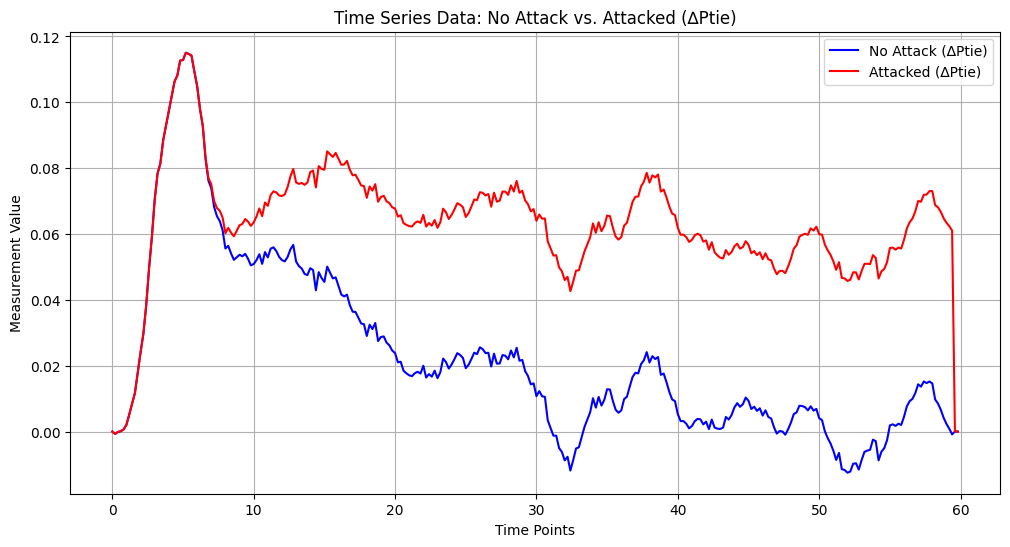

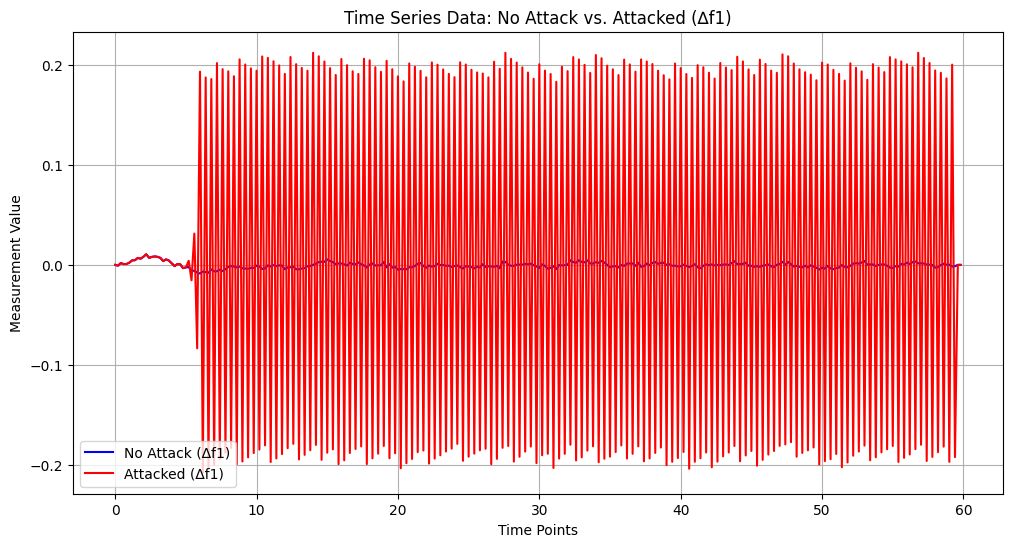

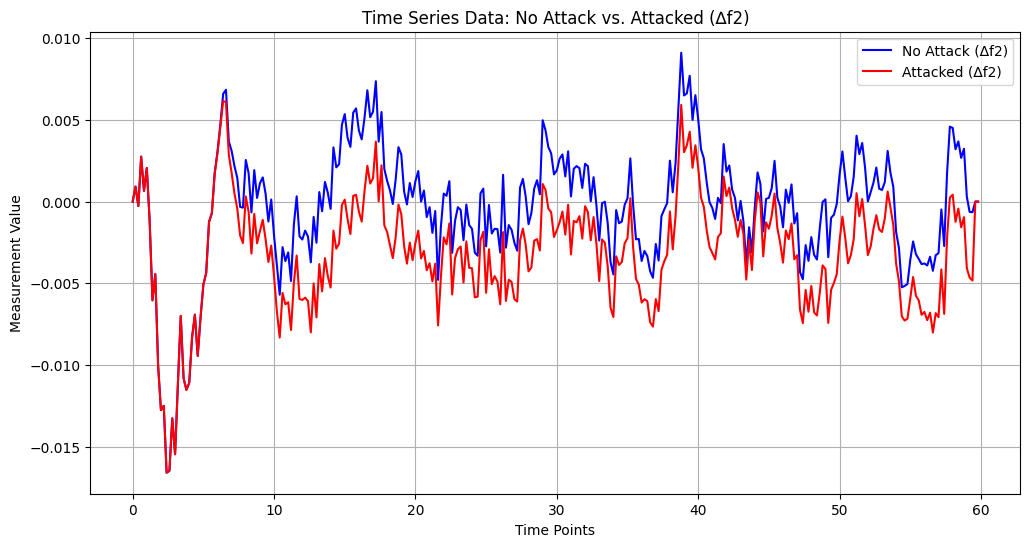

In [7]:
# Plotting each measurement separately for no attack vs. attacked

# Plot for Measurement 1
plt.figure(figsize=(12, 6))
plt.plot(time_points, solution_no_attack[0, 0, :], label='No Attack (∆Ptie)', color='blue')
plt.plot(time_points, solution_attacked[0, 0, :], label='Attacked (∆Ptie)', color='red')
plt.xlabel('Time Points')
plt.ylabel('Measurement Value')
plt.title('Time Series Data: No Attack vs. Attacked (∆Ptie)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Measurement 2
plt.figure(figsize=(12, 6))
plt.plot(time_points, solution_no_attack[0, 1, :], label='No Attack (∆f1)', color='blue')
plt.plot(time_points, solution_attacked[0, 1, :], label='Attacked (∆f1)', color='red')
plt.xlabel('Time Points')
plt.ylabel('Measurement Value')
plt.title('Time Series Data: No Attack vs. Attacked (∆f1)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Measurement 3
plt.figure(figsize=(12, 6))
plt.plot(time_points, solution_no_attack[0, 2, :], label='No Attack (∆f2)', color='blue')
plt.plot(time_points, solution_attacked[0, 2, :], label='Attacked (∆f2)', color='red')
plt.xlabel('Time Points')
plt.ylabel('Measurement Value')
plt.title('Time Series Data: No Attack vs. Attacked (∆f2)')
plt.legend()
plt.grid(True)
plt.show()



In [8]:
## Input features
dataset['train_input'].shape[1]

18

 ---
 # Model Training
 ---


## The model

In [9]:
image_folder = 'video_img'
model = KAN(width=[dataset['train_input'].shape[1], 32, 1], grid=3, k=3, seed=2025, device=device)

model(dataset['train_input'])

checkpoint directory created: ./model
saving model version 0.0


tensor([[-0.1028],
        [-0.0452],
        [-0.0838],
        ...,
        [-0.0716],
        [ 0.1448],
        [ 0.0643]], device='cuda:0', grad_fn=<AddBackward0>)

## Print the model graph

In [10]:
print(model)

MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)


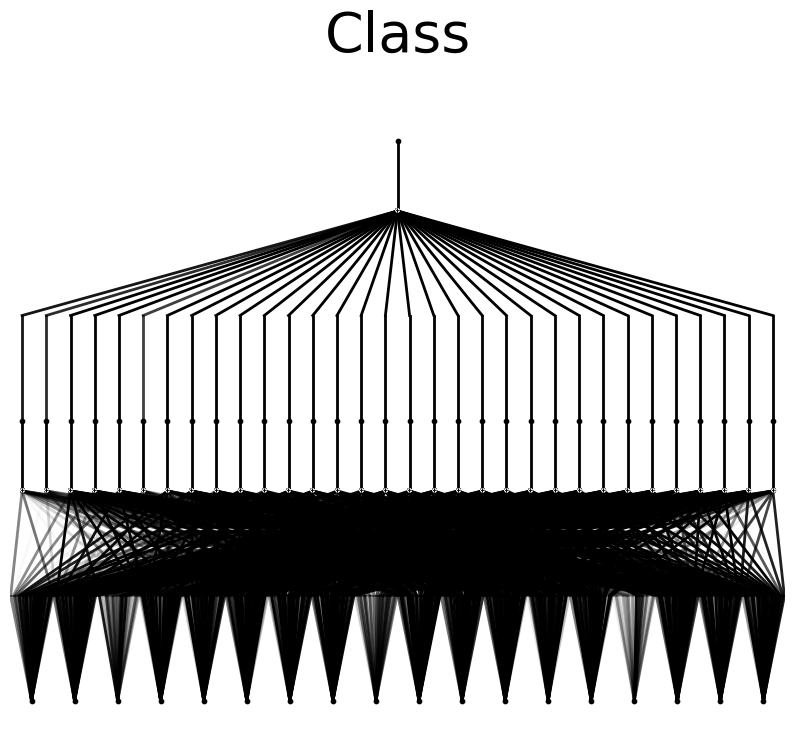

In [11]:

model.plot(beta=100, scale=1 , out_vars=['Class'])

## Train the model

In [12]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(testdataset['test_input']), dim=1) == testdataset['test_label']).float())

def val_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

Optimizer = "LBFGS"
Criterion = torch.nn.BCEWithLogitsLoss()

results = model.fit(dataset, opt=Optimizer , metrics=(train_acc, val_acc),
                      loss_fn=Criterion, steps=50, lamb=0.001,batch=128 , save_fig=False)

## To create Video
# results = model.fit(dataset, opt=Optimizer , metrics=(train_acc, test_acc),
#                       loss_fn=Criterion, steps=50, lamb=0.001, save_fig=True, img_folder=image_folder , batch=128, save_fig_freq=10)

| train_loss: 1.53e-01 | test_loss: 2.14e-01 | reg: 2.77e+01 | : 100%|█| 50/50 [00:18<00:00,  2.66it

saving model version 0.1


### The Model Metrics

Test Accuracy: 0.9728
Test Precision: 0.9802
Test Recall: 0.9650
Test F1-Score: 0.9725
Confusion Matrix:
[[1961   39]
 [  70 1930]]


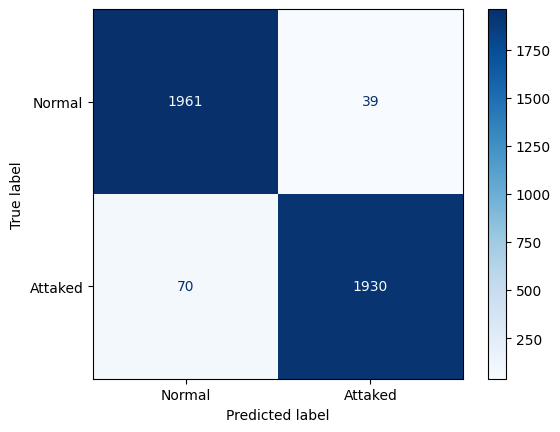

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict
y_test = testdataset["test_label"].cpu().numpy().flatten()
y_pred_prob = model(testdataset["test_input"]).detach().cpu().numpy().flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attaked"])
disp.plot(cmap="Blues")

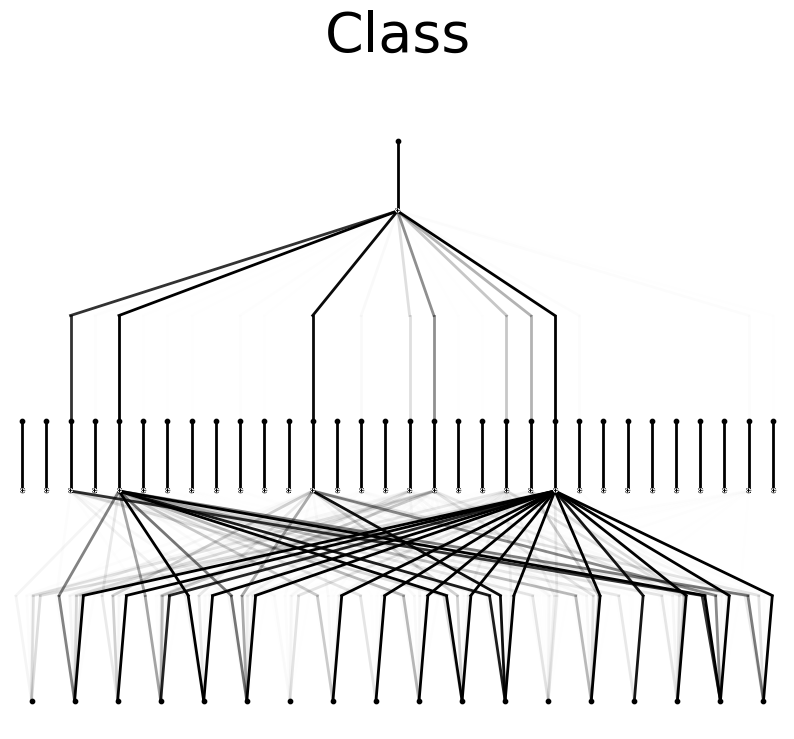

In [14]:
model.plot(beta=100, scale=1 , out_vars=['Class'])

#### To show the Video of the model

In [15]:
# import numpy as np # Import numpy here
# import moviepy.video.io.ImageSequenceClip # Import moviepy

# video_name='video'
# fps=10

# fps = fps
# files = os.listdir(image_folder)
# train_index = []
# for file in files:
#     if file[0].isdigit() and file.endswith('.jpg'):
#         train_index.append(int(file[:-4]))

# train_index = np.sort(train_index)

# image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

# clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
# clip.write_videofile(video_name+'.mp4')

### Find the symbolic equation using the Auto option / before Prune

In [16]:

lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']


model.auto_symbolic(lib=lib)
formula1 = model.symbolic_formula()[0]
print(formula1)



fixing (0,0,0) with x, r2=0.028178442269563675, c=1
fixing (0,0,1) with sin, r2=0.9952284097671509, c=2
fixing (0,0,2) with x, r2=0.018757928162813187, c=1
fixing (0,0,3) with x, r2=8.01851820142474e-06, c=1
fixing (0,0,4) with x, r2=0.1612400859594345, c=1
fixing (0,0,5) with x, r2=0.4415743052959442, c=1
fixing (0,0,6) with x, r2=0.16551552712917328, c=1
fixing (0,0,7) with x, r2=0.09233224391937256, c=1
fixing (0,0,8) with x, r2=0.1427229940891266, c=1
fixing (0,0,9) with x, r2=0.33398422598838806, c=1
fixing (0,0,10) with x, r2=0.13998796045780182, c=1
fixing (0,0,11) with x, r2=0.012488518841564655, c=1
fixing (0,0,12) with sin, r2=0.9871652722358704, c=2
fixing (0,0,13) with x, r2=0.03897351026535034, c=1
fixing (0,0,14) with x, r2=0.028291936963796616, c=1
fixing (0,0,15) with x, r2=0.08996365964412689, c=1
fixing (0,0,16) with sin, r2=0.991744339466095, c=2
fixing (0,0,17) with sin, r2=0.9914678335189819, c=2
fixing (0,0,18) with x, r2=0.07799716293811798, c=1
fixing (0,0,19) w

#### The formula

In [17]:
# from sympy import *

# # Access the expression within the list before simplifying
# simplify(formula1[0])

In [18]:

print("Variables in symbolic formula 1:")
if isinstance(formula1[0], sympy.Expr):
    print([str(symbol) for symbol in formula1[0].free_symbols])
else:
    print("symbolic formula 1 is not a SymPy expression.")


feature_names = []
measurements = ["Measurement 1", "Measurement 2", "Measurement 3"]
metrics = ["mean", "std", "min", "max", "skew", "kurtosis"]

for i in range(3): # For each measurement (channel)
    for metric in metrics:
        feature_names.append(f"{metric}_{measurements[i]}")

# The symbolic variables x_0 to x_17 correspond to these feature_names in order.
# E.g., x_0 is mean_Measurement 1, x_1 is std_Measurement 1, ..., x_17 is kurtosis_Measurement 3.

print("\nAll possible input features (corresponding to x_0 to x_17):")
for i, name in enumerate(feature_names):
    print(f"x_{i}: {name}")

# Find missing variables in formula1[0] from the input features
present_variables_in_formula = set()
if isinstance(formula1[0], sympy.Expr):
    present_variables_in_formula = {str(symbol) for symbol in formula1[0].free_symbols}

all_input_variable_names = {f'x_{i}' for i in range(len(feature_names))}

missing_variables = all_input_variable_names - present_variables_in_formula

print("\nMissing variables in symbolic formula 1 from the input features:")
if missing_variables:
    missing_list = sorted(list(missing_variables), key=lambda x: int(x.split('_')[1]))
    for var in missing_list:
        index = int(var.split('_')[1])
        print(f"{var} ({feature_names[index]})")
else:
    print("No missing variables. The symbolic formula 1 uses all input features.")


Variables in symbolic formula 1:
['x_17', 'x_15', 'x_11', 'x_7', 'x_5', 'x_6', 'x_9', 'x_2', 'x_8', 'x_12', 'x_4', 'x_16', 'x_13', 'x_14', 'x_1', 'x_10', 'x_3', 'x_18']

All possible input features (corresponding to x_0 to x_17):
x_0: mean_Measurement 1
x_1: std_Measurement 1
x_2: min_Measurement 1
x_3: max_Measurement 1
x_4: skew_Measurement 1
x_5: kurtosis_Measurement 1
x_6: mean_Measurement 2
x_7: std_Measurement 2
x_8: min_Measurement 2
x_9: max_Measurement 2
x_10: skew_Measurement 2
x_11: kurtosis_Measurement 2
x_12: mean_Measurement 3
x_13: std_Measurement 3
x_14: min_Measurement 3
x_15: max_Measurement 3
x_16: skew_Measurement 3
x_17: kurtosis_Measurement 3

Missing variables in symbolic formula 1 from the input features:
x_0 (mean_Measurement 1)


#### The metrics of the Symbolic formula

Evaluating symbolic formula on test set: 100%|██████████| 4000/4000 [51:36<00:00,  1.29it/s]


Accuracy of the Symbolic Formula on the test set: 0.8355
Precision of the Symbolic Formula on the test set: 0.7824
Recall of the Symbolic Formula on the test set: 0.9295
F1-Score of the Symbolic Formula on the test set: 0.8496
Confusion Matrix for Symbolic Formula:
[[1483  517]
 [ 141 1859]]


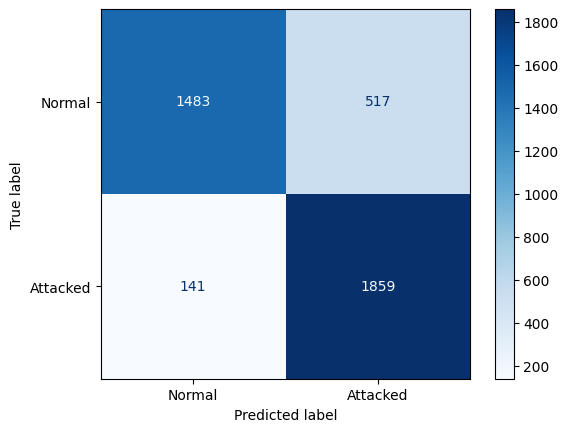

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import sympy

# Re-evaluating the symbolic formula on the test set
def kan_symbolic_formula_prediction_test(formula, X):
    batch = X.shape[0]
    predictions = []

    for i in tqdm(range(batch), desc="Evaluating symbolic formula on test set"):
        # Start with the base formula expression
        expression = formula


        substitutions = {sympy.Symbol(f'x_{j+1}'): X[i, j] for j in range(X.shape[1])}

        # Perform the substitution
        evaluated_expression = expression.subs(substitutions)

        # Evaluate the substituted expression numerically
        predicted = float(evaluated_expression.evalf())

        predictions.append(predicted)

    return predictions


preds_from_kan_formula_test1 = kan_symbolic_formula_prediction_test(formula1[0], testdataset['test_input'].cpu().numpy())

# Convert the list of test predictions to a numpy array
preds_test_np1 = np.array(preds_from_kan_formula_test1)

# Convert raw predictions (logits) to predicted classes (0 or 1)
# Use the same threshold as the KAN model ( > 0 for BCEWithLogitsLoss)
predicted_classes_formula_test1 = (preds_test_np1 > 0).astype(float)

# Get the true test labels
true_labels_test1 = testdataset['test_label'].cpu().numpy().flatten()

# Calculate accuracy on the test set
accuracy_formula_test1 = accuracy_score(true_labels_test1, predicted_classes_formula_test1)
precision_formula_test1 = precision_score(true_labels_test1, predicted_classes_formula_test1)
recall_formula_test1 = recall_score(true_labels_test1, predicted_classes_formula_test1)
f1_formula_test1 = f1_score(true_labels_test1, predicted_classes_formula_test1)


print()

print(f"Accuracy of the Symbolic Formula on the test set: {accuracy_formula_test1:.4f}")
print(f"Precision of the Symbolic Formula on the test set: {precision_formula_test1:.4f}")
print(f"Recall of the Symbolic Formula on the test set: {recall_formula_test1:.4f}")
print(f"F1-Score of the Symbolic Formula on the test set: {f1_formula_test1:.4f}")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for the symbolic formula predictions
cm_formula2 = confusion_matrix(true_labels_test1, predicted_classes_formula_test1)

# Print the matrix
print("Confusion Matrix for Symbolic Formula:")
print(cm_formula2)

# Optionally, visualize it
disp_formula = ConfusionMatrixDisplay(confusion_matrix=cm_formula2, display_labels=["Normal", "Attacked"])
disp_formula.plot(cmap="Blues")

## Prune and fine tuning

In [20]:
model

MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

saving model version 0.3


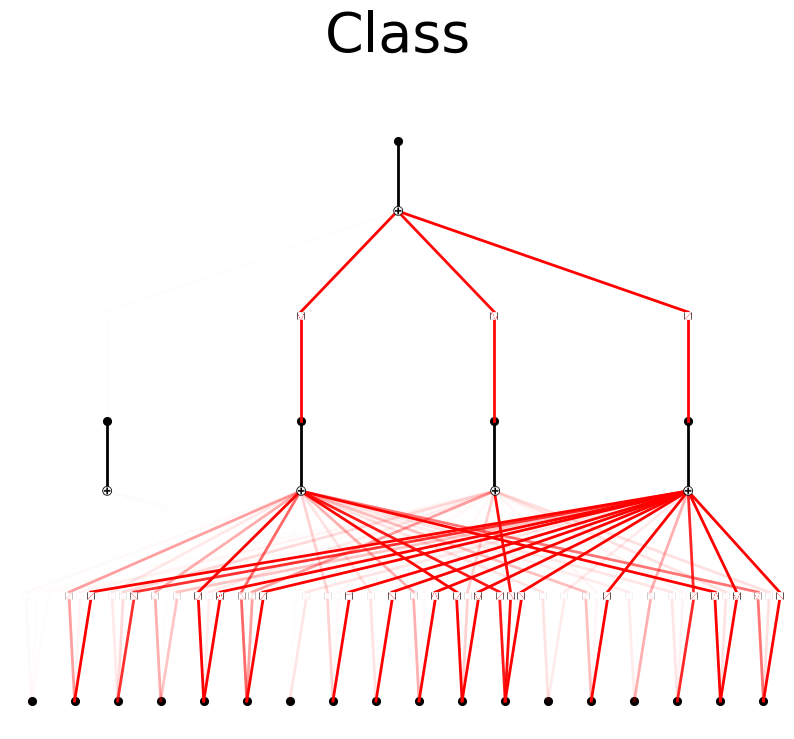

In [21]:
model10 = model.prune()
model10(dataset['train_input'])
model10.plot(beta=100, scale=1 , out_vars=['Class'])

In [22]:
# fine tune
Optimizer = "Adam" # Change optimizer to Adam
results_1 = model10.fit(dataset, opt=Optimizer, metrics=(train_acc, val_acc),
                      loss_fn=Criterion, steps=50, lamb=0.0001, batch=128 , lr=0.001) # Added lr for Adam

| train_loss: 5.22e-01 | test_loss: 2.32e-01 | reg: 0.00e+00 | : 100%|█| 50/50 [00:18<00:00,  2.68it

saving model version 0.4


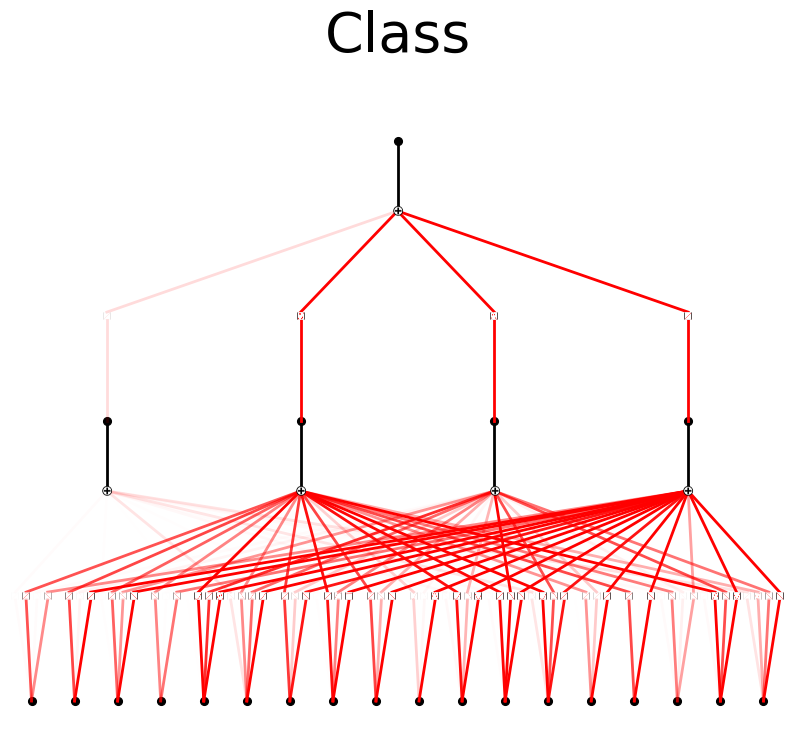

In [23]:
model10(dataset['train_input'])
model10.plot(beta=100, scale=1 , out_vars=['Class'])

### The metrics of the fine tuned model

Test Accuracy: 0.9597
Test Precision: 0.9656
Test Recall: 0.9535
Test F1-Score: 0.9595
Confusion Matrix:
[[1932   68]
 [  93 1907]]


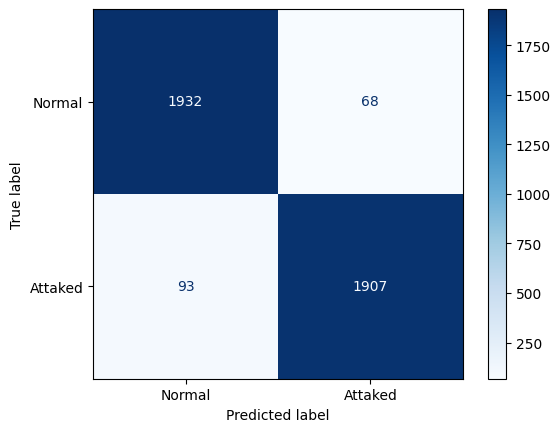

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict
y_test = testdataset["test_label"].cpu().numpy().flatten()
y_pred_prob = model10(testdataset["test_input"]).detach().cpu().numpy().flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate
acc1 = accuracy_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred)
recall1 = recall_score(y_test, y_pred)
f11 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {acc1:.4f}")
print(f"Test Precision: {precision1:.4f}")
print(f"Test Recall: {recall1:.4f}")
print(f"Test F1-Score: {f11:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attaked"])
disp.plot(cmap="Blues")

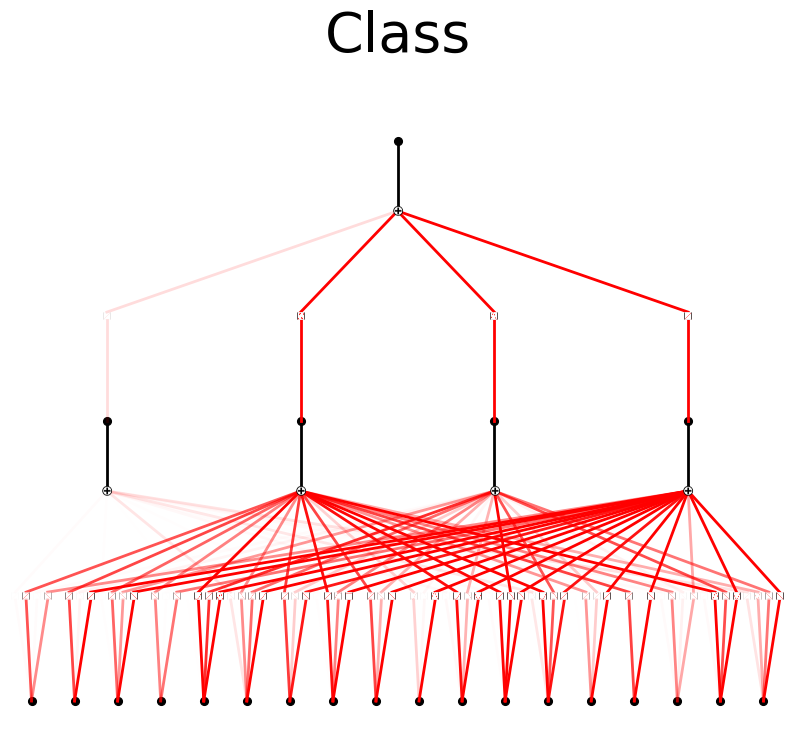

In [25]:
model10.plot(beta=100, scale=1 , out_vars=['Class'])

### Find the symbolic equation using the Auto option / After Prune

In [26]:

lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']


model10.auto_symbolic(lib=lib)
formula2 = model10.symbolic_formula()[0]
print(formula2)

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,0,2) since already symbolic
skipping (0,0,3) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,1,1) since already symbolic
skipping (0,1,2) since already symbolic
skipping (0,1,3) since already symbolic
skipping (0,2,0) since already symbolic
skipping (0,2,1) since already symbolic
skipping (0,2,2) since already symbolic
skipping (0,2,3) since already symbolic
skipping (0,3,0) since already symbolic
skipping (0,3,1) since already symbolic
skipping (0,3,2) since already symbolic
skipping (0,3,3) since already symbolic
skipping (0,4,0) since already symbolic
skipping (0,4,1) since already symbolic
skipping (0,4,2) since already symbolic
skipping (0,4,3) since already symbolic
skipping (0,5,0) since already symbolic
skipping (0,5,1) since already symbolic
skipping (0,5,2) since already symbolic
skipping (0,5,3) since already symbolic
skipping (0,6,0) since already symbolic


#### The formula

In [27]:
# from sympy import *

# # Access the expression within the list before simplifying
# simplify(formula2[0])

In [29]:

print("Variables in the symbolic formula 2:")
if isinstance(formula1[0], sympy.Expr):
    print([str(symbol) for symbol in formula1[0].free_symbols])
else:
    print("symbolic formula 2 is not a SymPy expression.")


feature_names = []
measurements = ["Measurement 1", "Measurement 2", "Measurement 3"]
metrics = ["mean", "std", "min", "max", "skew", "kurtosis"]

for i in range(3): # For each measurement (channel)
    for metric in metrics:
        feature_names.append(f"{metric}_{measurements[i]}")

# The symbolic variables x_0 to x_17 correspond to these feature_names in order.
# E.g., x_0 is mean_Measurement 1, x_1 is std_Measurement 1, ..., x_17 is kurtosis_Measurement 3.

print("\nAll possible input features (corresponding to x_0 to x_17):")
for i, name in enumerate(feature_names):
    print(f"x_{i}: {name}")

# Find missing variables in formula1[0] from the input features
present_variables_in_formula = set()
if isinstance(formula1[0], sympy.Expr):
    present_variables_in_formula = {str(symbol) for symbol in formula1[0].free_symbols}

all_input_variable_names = {f'x_{i}' for i in range(len(feature_names))}

missing_variables = all_input_variable_names - present_variables_in_formula

print("\nMissing variables in symbolic formula 2 from the input features:")
if missing_variables:
    missing_list = sorted(list(missing_variables), key=lambda x: int(x.split('_')[1]))
    for var in missing_list:
        index = int(var.split('_')[1])
        print(f"{var} ({feature_names[index]})")
else:
    print("No missing variables. The symbolic formula 2 uses all input features.")


Variables in the symbolic formula 2:
['x_17', 'x_15', 'x_11', 'x_7', 'x_5', 'x_6', 'x_9', 'x_2', 'x_8', 'x_12', 'x_4', 'x_16', 'x_13', 'x_14', 'x_1', 'x_10', 'x_3', 'x_18']

All possible input features (corresponding to x_0 to x_17):
x_0: mean_Measurement 1
x_1: std_Measurement 1
x_2: min_Measurement 1
x_3: max_Measurement 1
x_4: skew_Measurement 1
x_5: kurtosis_Measurement 1
x_6: mean_Measurement 2
x_7: std_Measurement 2
x_8: min_Measurement 2
x_9: max_Measurement 2
x_10: skew_Measurement 2
x_11: kurtosis_Measurement 2
x_12: mean_Measurement 3
x_13: std_Measurement 3
x_14: min_Measurement 3
x_15: max_Measurement 3
x_16: skew_Measurement 3
x_17: kurtosis_Measurement 3

Missing variables in symbolic formula 2 from the input features:
x_0 (mean_Measurement 1)


#### The metrics of the Symbolic formula

Evaluating symbolic formula on test set: 100%|██████████| 4000/4000 [10:11<00:00,  6.54it/s]


Accuracy of the Symbolic Formula on the test set: 0.9590
Precision of the Symbolic Formula on the test set: 0.9554
Recall of the Symbolic Formula on the test set: 0.9630
F1-Score of the Symbolic Formula on the test set: 0.9592
Confusion Matrix for Symbolic Formula:
[[1910   90]
 [  74 1926]]


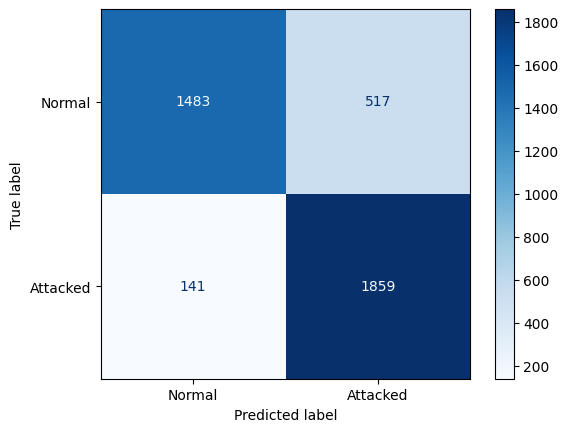

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import sympy

# Re-evaluating the symbolic formula on the test set
def kan_symbolic_formula_prediction_test(formula, X):
    batch = X.shape[0]
    predictions = []

    for i in tqdm(range(batch), desc="Evaluating symbolic formula on test set"):
        # Start with the base formula expression
        expression = formula


        substitutions = {sympy.Symbol(f'x_{j+1}'): X[i, j] for j in range(X.shape[1])}

        # Perform the substitution
        evaluated_expression = expression.subs(substitutions)

        # Evaluate the substituted expression numerically
        predicted = float(evaluated_expression.evalf())

        predictions.append(predicted)

    return predictions


preds_from_kan_formula_test2 = kan_symbolic_formula_prediction_test(formula2[0], dataset['test_input'].cpu().numpy())

# Convert the list of test predictions to a numpy array
preds_test_np2 = np.array(preds_from_kan_formula_test2)

# Convert raw predictions (logits) to predicted classes (0 or 1)
# Use the same threshold as the KAN model ( > 0 for BCEWithLogitsLoss)
predicted_classes_formula_test2 = (preds_test_np2 > 0).astype(float)

# Get the true test labels
true_labels_test2 = dataset['test_label'].cpu().numpy().numpy().flatten()

# Calculate accuracy on the test set
accuracy_formula_test2 = accuracy_score(true_labels_test2, predicted_classes_formula_test2)
precision_formula_test2 = precision_score(true_labels_test2, predicted_classes_formula_test2)
recall_formula_test2 = recall_score(true_labels_test2, predicted_classes_formula_test2)
f1_formula_test2 = f1_score(true_labels_test2, predicted_classes_formula_test2)


print()

print(f"Accuracy of the Symbolic Formula on the test set: {accuracy_formula_test2:.4f}")
print(f"Precision of the Symbolic Formula on the test set: {precision_formula_test2:.4f}")
print(f"Recall of the Symbolic Formula on the test set: {recall_formula_test2:.4f}")
print(f"F1-Score of the Symbolic Formula on the test set: {f1_formula_test2:.4f}")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for the symbolic formula predictions
cm_formula2 = confusion_matrix(true_labels_test2, predicted_classes_formula_test2)

# Print the matrix
print("Confusion Matrix for Symbolic Formula:")
print(cm_formula2)

# Optionally, visualize it
disp_formula = ConfusionMatrixDisplay(confusion_matrix=cm_formula2, display_labels=["Normal", "Attacked"])
disp_formula.plot(cmap="Blues")

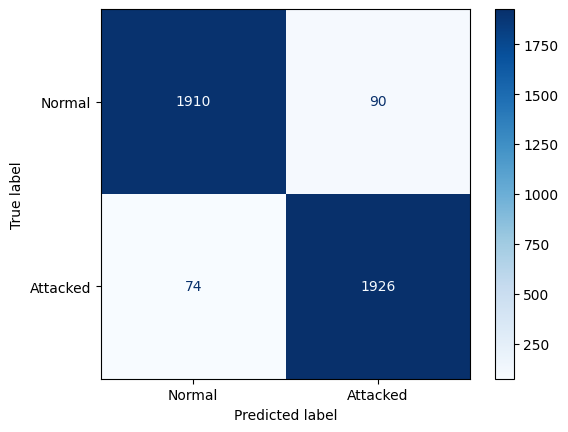

In [34]:
disp_formula = ConfusionMatrixDisplay(confusion_matrix=cm_formula2, display_labels=["Normal", "Attacked"])
disp_formula.plot(cmap="Blues")

 The results

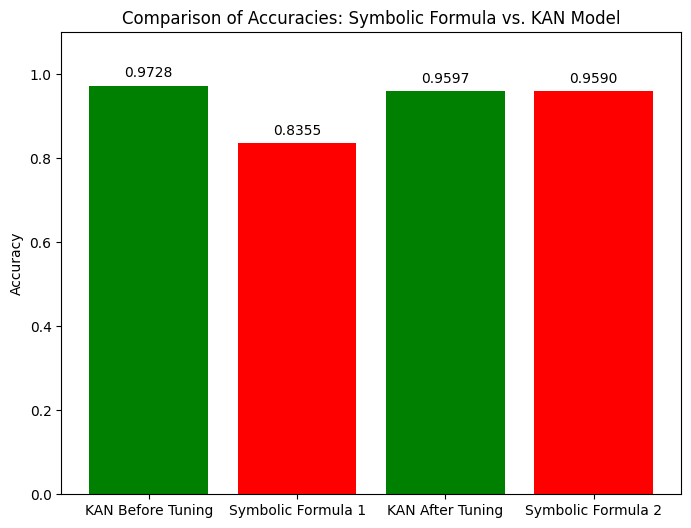

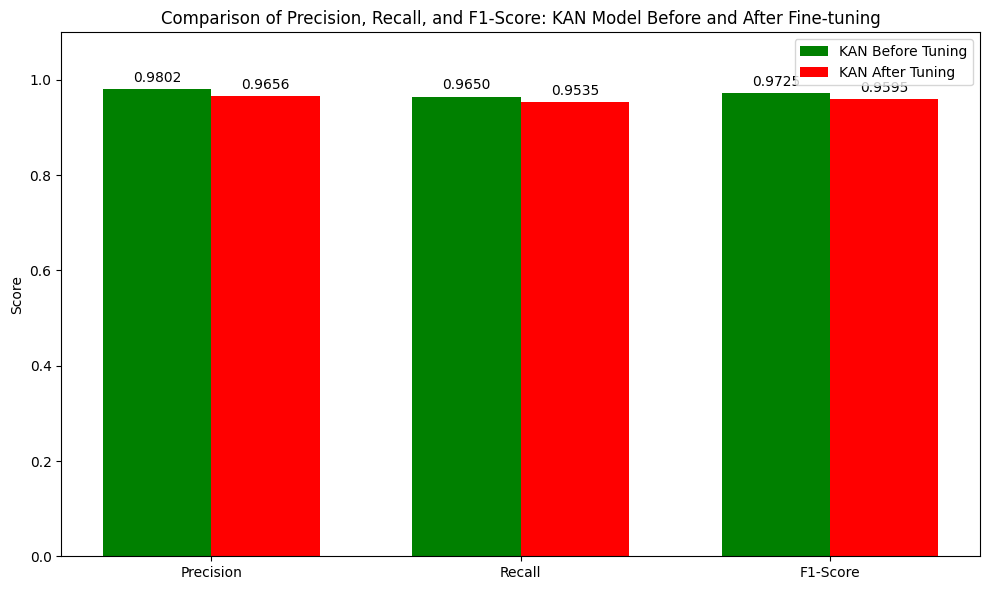

In [31]:
import matplotlib.pyplot as plt

symbolic_accuracy1 = accuracy_formula_test1
symbolic_accuracy2 = accuracy_formula_test2
kan_accuracy_before_tuning = acc
kan_accuracy_after_tuning = acc1
kan_precision_before_tuning = precision
kan_recall_before_tuning = recall
kan_f1_before_tuning = f1
kan_precision_after_tuning = precision1
kan_recall_after_tuning = recall1
kan_f1_after_tuning = f11



# Accuracies list for plotting
labels = ['KAN Before Tuning','Symbolic Formula 1', 'KAN After Tuning' , 'Symbolic Formula 2']
accuracies = [kan_accuracy_before_tuning, symbolic_accuracy1 , kan_accuracy_after_tuning , symbolic_accuracy2]

# Plotting the accuracies
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['green', 'red', 'green' , 'red'])
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies: Symbolic Formula vs. KAN Model')
plt.ylim(0, 1.1) # Set y-axis limit for better comparison
for i, acc_val in enumerate(accuracies):
    plt.text(i, acc_val + 0.02, f'{acc_val:.4f}', ha='center')
plt.show()


# Plotting Precision, Recall, and F1-score
metrics_labels = ['Precision', 'Recall', 'F1-Score']
kan_before_metrics = [kan_precision_before_tuning, kan_recall_before_tuning, kan_f1_before_tuning]
kan_after_metrics = [kan_precision_after_tuning, kan_recall_after_tuning, kan_f1_after_tuning]

x = np.arange(len(metrics_labels)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, kan_before_metrics, width, label='KAN Before Tuning', color='green')
rects2 = ax.bar(x + width/2, kan_after_metrics, width, label='KAN After Tuning', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Comparison of Precision, Recall, and F1-Score: KAN Model Before and After Fine-tuning')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.set_ylim(0, 1.1)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


## is the symbolic equation compeired with the model's behavouir ? or with the dataset ?